In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import folium
import os

In [3]:
%matplotlib inline

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,8)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,8)

In [4]:
file_path = os.getcwd()
print(file_path)

C:\Users\mirab\Dropbox\Deep Learning


-------------------------------------------------------

# Data preparation and description

Let's start by simply importing the datasets and doing some initial restructuring

In [5]:
# importing data
df_rentals = pd.read_csv(file_path+"/DR_Data/Rentals_2019-4-2_1456.csv", parse_dates=[0,1])
df_hubav = pd.read_csv(file_path+"/DR_Data/Hubavailabilityaudits_2019-4-2_1535.csv", parse_dates=[3])
df_hubs = pd.read_csv(file_path+"/DR_Data/Hubs_2019-4-2_1201.csv", parse_dates=[0,-1])
df_searchlog1 = pd.read_csv(file_path+"/DR_Data/Searchlogs_2019-4-2_1234.csv", parse_dates=[-1])
df_searchlog2 = pd.read_csv(file_path+"/DR_Data/Searchlogs_2019-4-2_1504.csv", parse_dates=[-1])

In [6]:
#concatenating searchlogs dataframes (the second file is a continuation of the first)
df_searchlog = pd.concat([df_searchlog1, df_searchlog2])

-----------------
## Overview

The data we will be dealing with belongs to Donkey Republic, a bike-sharing company operating in Copenhagen. The service offered by Donkey Republic falls under the family of *hub-based* bike-sharing services. This means that bikes can only be picked-up and dropped-off in specific areas - i.e. "virtual" areas (meaning that no physical platforms are installed) called hubs. Our goal will be to define a model for the prediction of bike usage demand in the various hubs. Having accurate predictions of demand will be the key element in order to take coherent decisions on the supply side (supply dimensioning, rebalancing, hub positioning, etc.).

Our dataset will be constituted by various measurements of the bike usage and of the service provider. The information available to us is organized in the following way:

1) *df_rentals*: represents the actual bike rentals indicating time and hub for both pick-up and drop-off, together with the user id associated with that rental

In [7]:
df_rentals.head(10)

,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,2163,2449.0,108186
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,2381,2381.0,113852
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,1513,1513.0,113912
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,2337,2337.0,113822
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,2153,233.0,113881
5,2018-03-03 13:22:27.557683,2018-03-03 13:40:09.817,2228,941.0,109897
6,2018-03-03 11:07:59.517016,2018-03-03 16:48:21.113,1165,1165.0,113990
7,2018-03-02 07:24:39.225679,2018-03-03 18:51:56.902,2226,1898.0,62726
8,2018-03-03 08:36:11.528752,2018-03-03 21:38:57.200,1736,1736.0,113955
9,2018-03-03 15:15:14.000417,2018-03-04 11:19:27.098,2426,2262.0,114049


2) *df_hubs*: describes various characteristics for each hub such as time of creation, geo-spatial location, id, name and (eventual) time of deletion

In [8]:
df_hubs.head(10)

,created_at,latitude,longitude,id,name,deleted_at
0,2018-05-21 09:35:00.697175,48.864936,2.310624,3268,Cours la Reine,2018-05-21 16:17:24.722283
1,2018-11-26 09:06:05.590590,55.695252,12.547185,6367,Heinesgade,NaT
2,2018-06-05 12:12:28.639837,55.676916,12.564896,3642,Concert Hall Pumpehuset,2018-11-15 10:45:34.468962
3,2018-05-28 20:07:34.173984,55.668700,12.551114,3526,Saxogade,NaT
4,2018-11-08 09:36:50.440822,55.699557,12.515065,6233,GrÃ¸ndal Multicenter,NaT
5,2018-01-16 19:05:49.192033,55.682669,12.577611,2350,Egmont,NaT
6,2018-01-09 14:53:52.744834,55.668653,12.543646,2276,Vega,NaT
7,2019-03-14 11:39:00.814359,55.697218,12.584605,7148,SÃ¸nderborggade,NaT
8,2018-07-22 15:03:16.438551,55.669671,12.545824,4947,MatthÃ¦usgade,NaT
9,2019-03-20 13:50:30.943318,55.678997,12.586016,7316,Kongens Nytorv,NaT


3) *df_searchlog*: represents the geo-localization of users in the moment they access the app. For every search it describes location, time and user_id 

In [9]:
df_searchlog.head(10)

,user_location_latitude,user_location_longitude,anonymous_id,user_id,timestamp
0,55.663360,12.563741,B755142C-DBAA-437A-818B-5358E2982D59,119409.0,2018-04-01 00:19:09.229
1,55.684639,12.553777,F6ADD77A-B26C-407B-BE83-78294FE80D0B,119568.0,2018-04-01 06:40:22.853
2,55.674647,12.559726,8A0521A3-0183-45F3-BF80-05DC01245205,112257.0,2018-04-01 06:49:29.184
3,55.705648,12.542835,3B38FBCA-4DB1-44A4-9DF4-5979B29FD6EA,NaN,2018-04-01 07:06:18.953
4,55.626786,12.576799,6221B6B0-FEA2-4A8D-8CB5-72BCC93B01A7,113593.0,2018-04-01 07:25:03.517
5,55.674814,12.559693,B1A013E2-692C-4B9F-B975-D7412B69E49C,116550.0,2018-04-01 07:26:22.414
6,55.667523,12.585956,4BDF423C-8F62-4DC5-B688-D84F1C92540F,NaN,2018-04-01 07:55:12.593
7,55.676079,12.573919,0983A326-140C-4837-ACC7-D94307071029,119203.0,2018-04-01 08:01:44.947
8,55.688612,12.562045,36062CE5-827F-4F68-B33D-F5CAAD6C5DFE,NaN,2018-04-01 08:06:36.777
9,55.688612,12.562045,36062CE5-827F-4F68-B33D-F5CAAD6C5DFE,119604.0,2018-04-01 08:10:51.799


4) *df_hubav*: represents the availability of bikes for every hub and how it evolved with time. In particular, at a certain timestamp "created_at", the bike count in a specific hub goes from the value in "bike_count_from" to the one in "bike_count_to". To give an example, if at a certain timestamp there has been a drop-off, and the previous availability of bikes was 8 (bike_count_from), then the new availability would be 9 (bike_count_to). 

This table also shows values for optimal and maximum capacity of bikes for every hub. It is already possible to notice some anamalous values in the data (i.e. 0 maximum capacity) which definitely need some further inspection...

In [10]:
df_hubav.head(10)

,hub_id,bike_count_from,bike_count_to,created_at,optimal_capacity,maximum_capacity
0,2529,9,10,2018-03-16 09:54:28.067837,10,20
1,2163,9,8,2018-10-09 14:20:41.388592,4,6
2,2358,9,10,2018-06-27 07:57:11.609790,3,3
3,152,9,8,2018-10-09 13:20:30.162299,4,6
4,1736,9,8,2018-06-21 09:15:06.729116,0,0
5,2165,9,8,2018-10-08 13:58:51.901203,4,4
6,2400,9,8,2018-05-26 14:14:29.632720,4,4
7,2161,9,8,2018-10-10 15:21:23.944951,0,6
8,1728,9,8,2018-06-29 06:06:26.773561,20,30
9,4155,9,10,2018-10-14 12:31:53.604268,4,6


Before going in more datail, here are some first general descriptions for the our four tables:

In [11]:
df_rentals.describe()

,pickup_hub_id,dropoff_hub_id,user_id
count,279860.000000,261293.000000,279860.000000
mean,2968.636633,2994.720494,225811.069831
std,1474.514389,1483.243813,79155.081485
min,49.000000,49.000000,1.000000
25%,2178.000000,2180.000000,162493.000000
50%,2413.000000,2431.000000,232322.000000
75%,3543.000000,3730.000000,293800.000000
max,7521.000000,7521.000000,357173.000000


In [12]:
df_hubs.describe()

,latitude,longitude,id
count,1266.000000,1266.000000,1266.000000
mean,55.500556,12.462749,4522.648499
std,2.762811,1.040837,1893.527454
min,0.000000,0.000000,49.000000
25%,55.664906,12.540773,2521.250000
50%,55.678197,12.566305,4945.000000
75%,55.693147,12.586798,6250.750000
max,55.789469,12.650923,7419.000000


In [13]:
df_searchlog.describe()

,user_location_latitude,user_location_longitude,user_id
count,1.054525e+06,1.054525e+06,839654.000000
mean,5.567888e+01,1.256690e+01,210313.372032
std,1.999616e-02,3.039608e-02,78701.220294
min,5.556344e+01,1.234982e+01,-1.000000
25%,5.566933e+01,1.255142e+01,146528.000000
50%,5.567814e+01,1.256913e+01,207102.000000
75%,5.568794e+01,1.258502e+01,273023.000000
max,5.581406e+01,1.282249e+01,356934.000000


In [14]:
df_hubav.describe()

,hub_id,bike_count_from,bike_count_to,optimal_capacity,maximum_capacity
count,825757.000000,825757.000000,825757.000000,825757.000000,825757.000000
mean,2976.156298,1.926315,1.940990,3.094558,4.566334
std,1480.907192,1.758047,1.760766,7.160294,7.042641
min,49.000000,0.000000,0.000000,0.000000,0.000000
25%,2177.000000,1.000000,1.000000,2.000000,3.000000
50%,2428.000000,2.000000,2.000000,3.000000,4.000000
75%,3665.000000,3.000000,3.000000,4.000000,6.000000
max,7549.000000,42.000000,42.000000,260.000000,250.000000


----------------------------------

## Hubs

In what follows we aim at visualizing on the map of Copenhagen all the existing (and deleted) hubs in our dataset. In order to do this we first need to differentiate between the still existing-hubs and the deleted ones:

In [15]:
# Centered location (latitude, longitude) which we will use in all our following plots
initial_location = [55.6775757, 12.579571639999999]

In [16]:
df_deleted_hubs = df_hubs.where(pd.notna(df_hubs.deleted_at) == True).dropna()

In [17]:
df_deleted_hubs.head(10)

,created_at,latitude,longitude,id,name,deleted_at
0,2018-05-21 09:35:00.697175,48.864936,2.310624,3268.0,Cours la Reine,2018-05-21 16:17:24.722283
2,2018-06-05 12:12:28.639837,55.676916,12.564896,3642.0,Concert Hall Pumpehuset,2018-11-15 10:45:34.468962
16,2018-01-22 15:47:39.318344,55.690060,12.554953,2378.0,Solitudvej,2018-12-03 15:52:51.137800
19,2018-04-15 09:19:30.266989,55.683848,12.562526,2850.0,Finsensvej,2018-11-07 14:29:06.066021
21,2017-07-05 08:47:19.611345,55.686668,12.585904,1521.0,Adelgade,2018-12-12 18:28:38.467796
22,2018-08-13 08:41:59.812525,55.679776,12.591652,5202.0,Nyhavn 49,2018-09-07 14:09:12.782407
30,2018-07-11 11:42:08.466632,55.678256,12.602834,4791.0,Halvtolv,2018-07-27 11:30:36.790366
39,2018-11-13 10:32:50.794717,55.673889,12.589137,6262.0,Strandgade Temp,2018-12-19 09:37:34.661184
44,2018-01-22 15:58:22.227920,55.686211,12.561416,2383.0,Peblinge Dossering,2018-11-15 10:54:37.329441
47,2018-06-21 12:54:38.647923,55.697299,12.557030,4056.0,NÃ¸ddebogade,2018-11-15 11:52:11.962632


In [18]:
df_existing_hubs = df_hubs.where(pd.notna(df_hubs.deleted_at) == False).dropna(how='all')

In [19]:
df_existing_hubs.head(10)

,created_at,latitude,longitude,id,name,deleted_at
1,2018-11-26 09:06:05.590590,55.695252,12.547185,6367.0,Heinesgade,NaT
3,2018-05-28 20:07:34.173984,55.668700,12.551114,3526.0,Saxogade,NaT
4,2018-11-08 09:36:50.440822,55.699557,12.515065,6233.0,GrÃ¸ndal Multicenter,NaT
5,2018-01-16 19:05:49.192033,55.682669,12.577611,2350.0,Egmont,NaT
6,2018-01-09 14:53:52.744834,55.668653,12.543646,2276.0,Vega,NaT
7,2019-03-14 11:39:00.814359,55.697218,12.584605,7148.0,SÃ¸nderborggade,NaT
8,2018-07-22 15:03:16.438551,55.669671,12.545824,4947.0,MatthÃ¦usgade,NaT
9,2019-03-20 13:50:30.943318,55.678997,12.586016,7316.0,Kongens Nytorv,NaT
10,2018-01-12 10:51:37.354963,55.656739,12.588744,2288.0,DR Byen,NaT
11,2018-08-17 13:07:30.532426,55.646583,12.529995,5252.0,Sydhavn Teater,NaT


Ok, so now we are ready to plot the hubs on the map differentiating the existing (in blue) from the deleted (in red) 

In [20]:
# Getting latitude-longitude locations for all the hubs
existing_locations = df_existing_hubs.iloc[:, 1:3].values.tolist()
del_hub_locations = df_deleted_hubs.iloc[:, 1:3].values.tolist()

In [21]:
hub_map = folium.Map(location=initial_location, zoom_start=13)

for point in range(0, len(existing_locations)):
    folium.CircleMarker(
    location=existing_locations[point],
    radius=3,
    popup='Hub_{}'.format(df_existing_hubs.iloc[point, 3]),
    color='#3186cc',
    fill=True,
    fill_color='#3186cc').add_to(hub_map)
    
for point in range(0, len(del_hub_locations)):
    folium.CircleMarker(
    location=del_hub_locations[point],
    radius=3,
    popup='Hub_{}'.format(df_deleted_hubs.iloc[point, 3]),
    color='crimson',
    fill=True,
    fill_color='crimson').add_to(hub_map)
    
hub_map

NameError: name 'folium' is not defined

<br>

-----------------

## Rentals

Being our goal the prediction of bike demand in the various hubs, the "Rentals" DataFrame definitely plays a central role. This will be the source of our observed demand in each hub. As we have seen above, this dataset is for now missing any kind of aggregation, meaning that our bike rentals are only recorded as individual instances on the timeline of our data.

This definitely leaves a lot of space for modeling: we could choose to aggregate our data at different levels (e.g. we could count the rentals for every hour/day/week/month). Obviously this depends on what is the type of decisions we want to take after having extracted information from our data. In our case, the decision will mostly have (at least initially) an operational level i.e. short-medium term. Therefore we are naturally more interested in a higher granularity of our data. 

For example, the following plots regard the daily time-series of pick-ups in a specific hub (Hub #60).

(before actually being able to plot our data we must fill in a "0" value for all those days where we don't have any recorded rental, in what follows we construct a DataFrame df_hub_60 which has the complete time series of pick-ups in Hub #60)

In [22]:
incomplete_index = pd.DatetimeIndex(pd.DatetimeIndex(df_rentals[df_rentals.pickup_hub_id == 60].created_at).date)
complete_index = pd.date_range(incomplete_index.min(),incomplete_index.max())
complete_index

DatetimeIndex(['2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07',
               '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11',
               '2018-03-12', '2018-03-13',
               ...
               '2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31',
               '2019-04-01', '2019-04-02'],
              dtype='datetime64[ns]', length=395, freq='D')

The two following cells give a representation of the type of imputation we just implemented:

In [23]:
df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d') \
.value_counts().sort_index().fillna(value=0).head(10)

2018-03-04    2
2018-03-05    1
2018-03-07    1
2018-03-08    1
2018-03-10    1
2018-03-11    4
2018-03-12    1
2018-03-14    3
2018-03-17    2
2018-03-18    5
Name: created_at, dtype: int64

In [24]:

df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d').value_counts().sort_index() \
.reindex(complete_index).fillna(value=0).head(10)

2018-03-04    2.0
2018-03-05    1.0
2018-03-06    0.0
2018-03-07    1.0
2018-03-08    1.0
2018-03-09    0.0
2018-03-10    1.0
2018-03-11    4.0
2018-03-12    1.0
2018-03-13    0.0
Freq: D, Name: created_at, dtype: float64

We are now ready to plot...

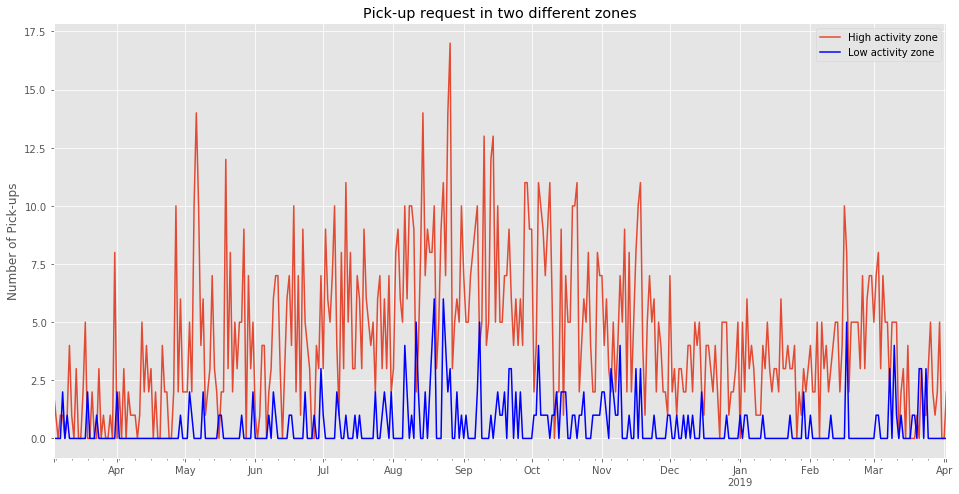

In [34]:

df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d').value_counts().sort_index(). \
reindex(complete_index).fillna(value=0).plot(style='-',label = 'High activity zone')
df_rentals[df_rentals.pickup_hub_id ==2276].created_at.dt.floor('d').value_counts().sort_index(). \
reindex(complete_index).fillna(value=0).plot(style='-',color='b',label = 'Low activity zone')
plt.title("Pick-up request in two different zones")
plt.legend()
plt.ylabel("Number of Pick-ups")
plt.show()

In the above plot we can observe a relevant increment in the observed demand especially during the summer (or close-to-summer) months. Other than leading us to explore some sort of seasonality this could also suggest that our data is actually generated from two distinct processes...

In the following graph we try to give a sense of this dual nature by plotting the histogram of the pickup counts (in Hub #60) by roughly trying to isolate the central part of our time-series: the "*nice weather*" data.

In [ ]:
# As a rough separation the data is devided in 3 parts (using the "official" summer dates: 21 Jun - 23 Sep)
summer_start_idx = int(np.where(df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d').value_counts()
                    .sort_index().index == pd.to_datetime('2018-06-21'))[0])
summer_end_idx = int(np.where(df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d').value_counts()
                       .sort_index().index == pd.to_datetime('2018-9-23'))[0])

In [ ]:
df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d').value_counts().sort_index() \
.reindex(complete_index).fillna(value=0)[:summer_start_idx].hist(bins=50)
plt.title("Pre-Summer Pick-up count distribution in Hub #60 (Norreport Area)")

plt.ylabel("Frequency")
plt.xlabel("Pick-up count")
plt.xlim([0,18])
plt.show()

In [ ]:
df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d').value_counts().sort_index() \
.reindex(complete_index).fillna(value=0)[summer_start_idx:summer_end_idx].hist(bins=50)
plt.title("Summer Pick-up count distribution in Hub #60 (Norreport Area)")
plt.ylabel("Frequency")
plt.xlabel("Pick-up count")
plt.xlim([0,18])
plt.show()

In [ ]:
df_rentals[df_rentals.pickup_hub_id == 60].created_at.dt.floor('d').value_counts().sort_index() \
.reindex(complete_index).fillna(value=0)[summer_end_idx:].hist(bins=50)
plt.title("Post-Summer Pick-up count distribution in Hub #60 (Norreport Area)")
plt.ylabel("Frequency")
plt.xlabel("Pick-up count")
plt.xlim([0,18])
plt.show()

It is therefore reasonable to think that our model should try to extract information from these temporal indicators in our data.

It is also important to stress the fact that these plots represent exclusively the pick-up rates for a single hub. We could have chosen to concentrate on the observation of origin-destination rentals (and so focus more on the demand of transportation from Hub A to Hub B rather than the pick-up demand in one hub).

---------------------------

## Hub availability

In the specification of our demand prediction problem it is important to notice that the realizations of demand that we observe in every hub are actually *censored*. This basically means that our variable of interest (the demand) has as upper limit the current supply of bikes. For example, suppose that we have a capacity of 10 bikes in one hub, we will never be able to observe a demand of 15, but only a maximum of 10. This behaviour will lead to an observed demand which could be an underestimate of the *real* demand (and therefore to a biased predictor)

An indicator of this censoring behaviour in our data could be observed in all those cases where the current availability of the hub reaches a value of 0. Obviously, a hub with no bikes available would not be able to satisfy any existing demand (and we would not be able therefore to observe any rentals).

The following plot represents the **minimum value** of bike availability in Hub #60 aggregated to a daily level:

(Again, the two following cells give a visual understanding of the preprocessing)

In [ ]:
# Odered representation of Hub dataset
df_hubav[df_hubav.hub_id == 60].sort_values(by='created_at').head(10)

In [ ]:
# Minimum availability for each of the sample days
df_hubav[df_hubav.hub_id == 60].groupby(pd.Grouper(key='created_at',freq='d')).min().bike_count_to.head(3)

By inspecting the data, we notice that we have missing availability records for some days. It turns out (as one would expect) that this is due to an unchanged availability in the corresponding Hub. Therefore, in this case it makes complete sense to fill in the missing days with a "*forward fill*" method:

In [ ]:
# Before fill
df_hubav[df_hubav.hub_id == 60].groupby(pd.Grouper(key='created_at',freq='d')).min().bike_count_to.head(10)

In [ ]:
# After fill
df_hubav[df_hubav.hub_id == 60].groupby(pd.Grouper(key='created_at',freq='d')).min(). \
bike_count_to.fillna(method='ffill').head(10)

We are now ready to analyse the plot:

In [ ]:
df_hubav[df_hubav.hub_id == 60].groupby(pd.Grouper(key='created_at',freq='d')).min().bike_count_to.fillna(method='ffill').plot()
plt.title("Minimum Daily Bike Availability in Hub #60 (Norreport Area)")
plt.ylabel("Minimum availability")
plt.xlabel("Day")
plt.show()

The plot clearly shows that (in this specific Hub) it is very common for the bike availability to go to 0 during the day (approximately 69% of the days)

-----------------------

## Searchlogs

We have seen how our data naturally defines a difference between *observed* and *real* demand. In this perspective, the searchlog data could represent some kind of indicator of the real demand. This data, as we described above, represents the locations of the users in the moment they access the app. It is therefore reasonable to assume that most of the access logs will represent users actually looking for an available bike nearby... 

To give a visual representation of the searchlogs the following plot represents 1000 searchlogs of 09/03/2019:

In [ ]:
df_searchlog['date'] = [d.date() for d in df_searchlog['timestamp']]
df_search_plot = df_searchlog.where(df_searchlog.date == pd.to_datetime("09/03/2019", format="%d/%m/%Y").date()).dropna()

In [ ]:
m = folium.Map(location=initial_location,
              zoom_start=13)

locations = df_search_plot.iloc[:1000, :2]
locationlist = locations.values.tolist()

for point in range(0, len(locationlist)):
    folium.CircleMarker(
    location=locationlist[point],
    radius=3,
    popup='Searchlog_{}'.format(point),
    color='#3186cc',
    fill=True,
    fill_color='#3186cc').add_to(m)
    
m

In [ ]:
m.save('fig/hub_visualization.html')

------------------

## User-specific level

Our data gives us valuable information on the rental patterns of single users. It could therefore be interesting to try and extrapolate patterns related to single individuals in our dataset. 

For example, in the following cells we first count how many rentals are recorded for every user (ordering from most active user to less active user). Then, for our plot, we select the most active user and analyse his origin-destination pattern.

In [ ]:
# Rental counts for every user
rentals_by_user = df_rentals.groupby('user_id')['user_id'].count().sort_values(ascending=False)
rentals_by_user.head(10)

In [ ]:
# Trips for user 140961 (most active in our dataset)
usr_140961 = df_rentals[df_rentals.user_id == 140961][['pickup_hub_id', 'dropoff_hub_id']].dropna()
usr_140961.head(10)

Let's also visualize the first 450 rentals on a map. In particular the blue markers represent the Pick-up locations, while the red markers represent the drop-off locations. 

Notice how: 
1. The area of Copenhagen is a pretty well defined subset of the entire city and 
2. The number of observable hubs is actually way less than 450 (this means that there is a high overlap between the plotted OD pairs - the user has several repetitive trips).

In [ ]:
user_map = folium.Map(location=initial_location,
              zoom_start=13)

locations = usr_140961.iloc[:,:]
locationlist = locations.values.tolist()

for point in range(0, len(locationlist[:450])):
    folium.CircleMarker(
    location=[df_hubs[df_hubs.id == int(locationlist[point][0])]['latitude'].values[0],df_hubs[df_hubs.id == int(locationlist[point][0])]['longitude'].values[0]],
    radius=3,
    popup='Rental_{}'.format(point),
    color='#3186cc',
    fill=True,
    fill_color='#3186cc').add_to(user_map)
    
    folium.CircleMarker(
    location=[df_hubs[df_hubs.id == int(locationlist[point][1])]['latitude'].values[0],df_hubs[df_hubs.id == int(locationlist[point][1])]['longitude'].values[0]],
    radius=3,
    popup='Rental_{}'.format(point),
    color='crimson',
    fill=True,
    fill_color='crimson').add_to(user_map)
    
user_map